In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
###

from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import r2_score

import torch
torch.manual_seed(0)
np.random.seed(42)


In [2]:
class CNC_Data():
    def __init__(self,df):
        self.df=df
       
        self.y=torch.from_numpy(np.array(self.df[['tool_condition', 'feed_rate', 'clamp_pressure']]))
        self.x=torch.from_numpy(np.array(self.df.drop(['tool_condition', 'feed_rate', 'clamp_pressure'],axis=1)))
        self.n_samples=self.df.shape[0]
    def __getitem__(self, index):
        return self.x[index],self.y[index]
        

    def __len__(self):
        return self.n_samples

In [3]:
data=pd.read_csv('./CNC_Processed_20231101.csv')
data=data.drop('Unnamed: 0',axis=1)


In [4]:

x = data #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled,columns=data.columns,index=data.index)

In [5]:
train_data,test_data=train_test_split(df,test_size=.30,shuffle = True, stratify = df[['feed_rate', 'clamp_pressure']])



train_df=CNC_Data(train_data)
test_df=CNC_Data(test_data)


train_dataloader=torch.utils.data.DataLoader(dataset=train_df,batch_size=64,shuffle=False)
test_dataloader=torch.utils.data.DataLoader(dataset=test_df,batch_size=64,shuffle=False)




In [6]:
class AutoEncoder(nn.Module):
    
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        #encoder
        self.e1 = nn.Linear(26,32)
        self.e2= nn.Linear(32,64)
        self.e3 = nn.Linear(64,128)
        self.e4 = nn.Linear(128,64)
        self.e5 = nn.Linear(64,32)
       

        self.dropout = nn.Dropout(0.20)
        
        #Latent View
        self.e6 = nn.Linear(32,16)
        self.e7 = nn.Linear(16,3)
     
        self.d1 = nn.Linear(3,16)
        self.d2 = nn.Linear(16,32)
        self.d3 = nn.Linear(32,64)
        self.d4 = nn.Linear(64,128)
        self.d5 = nn.Linear(128,64)
        self.d6 =nn.Linear(64,32)
        self.d7 =nn.Linear(32,26)
        
     
    def forward(self,x):
        encoded=self.forward_encode(x)
        decoded=self.forward_decode(encoded)
        return encoded,decoded
        
        
    def forward_encode(self,x):
        x = F.relu(self.e1(x))
        x = F.relu(self.e2(x))
        x = self.dropout(x)
        x = F.relu(self.e3(x))
        x= F.relu(self.e4(x))
        x = self.dropout(x)
        x = F.relu(self.e5(x))
        x= F.relu(self.e6(x))
        x = self.dropout(x)
        x = F.relu(self.e7(x))
        return x

    def forward_decode(self,x):
        x = F.relu(self.d1(x))
        x = F.relu(self.d2(x))
        x = self.dropout(x)
        x = F.relu(self.d3(x))
        x = F.relu(self.d4(x))
        x = self.dropout(x)
        x = F.relu(self.d5(x))
        x = F.relu(self.d6(x))
        x = self.dropout(x)
        x = F.relu(self.d7(x))
        return x
  

In [7]:


def train_vanila(epochs):
  b_encoder=[]
  b_decoder=[]

  # alphas=[0.01,0.02,0.5,0.03,0.4,0.9]
  
  
  encoeder = AutoEncoder()
  device=torch.device("cuda")
  best_Encoder=100000
  best_decoder=100000
  encoeder.to(device)
  loss_function_encoder = nn.MSELoss()
  loss_function_decoder = nn.L1Loss()
  optim_encode= torch.optim.Adam(encoeder.parameters(), lr=0.00001,weight_decay=0.001)
  y_loss = {}  # loss history
  y_loss['train_encoder'] = []
  y_loss['train_decoder'] = []
  y_loss['test_encoder'] = []
  y_loss['test_decoder'] = []

  y_rmse = {}
  y_rmse['train_encoder'] = []
  y_rmse['train_decoder'] = []
  y_rmse['test_encoder'] = []
  y_rmse['test_decoder'] = []

  y_rsquare={}

  y_rsquare['test_encoder'] = []
  y_rsquare['test_decoder'] = []




  for epoch in range(epochs):
      
      # Print epoch
      print(f'Starting epoch {epoch+1}')
      
      # Set current loss value
      current_loss_train_encoder=0.0
      current_loss_train_decoder = 0.0
      
      # Iterate over the DataLoader for training data
      for i, data in enumerate( train_dataloader, 0):
              
        # Get and prepare inputs
        inputs, targets = data
        inputs, targets = inputs.float().to(device), targets.float().to(device)
        
        # Zero the gradients
        optim_encode.zero_grad()
  
        # Perform forward pass
      
        regression_out,reconstruction=encoeder(inputs)
        
        
        
        # Compute loss
        loss_train_encoder = loss_function_encoder(regression_out, targets)
        y_rmse['train_encoder'].append(r2_score(regression_out.cpu().detach().numpy(), targets.cpu().detach().numpy()))
        
        
        # Perform backward pass
        
        
        
        
        # reconstruction=decoder(regression_out )
        loss_train_decoder=loss_function_decoder(reconstruction,inputs)
        #adding losses
          
        loss_total=loss_train_encoder+loss_train_decoder
        loss_total.backward()
        
      
        y_rmse['train_decoder'].append(r2_score(reconstruction.cpu().detach().numpy(),inputs.cpu().detach().numpy()))
  
        
          
        current_loss_train_encoder+=loss_train_encoder.item()
        current_loss_train_decoder+=loss_train_decoder.item()
        # Perform optimization
        optim_encode.step()
        # optim_decode.step()

    



      current_loss_train_encoder /= len(train_dataloader)
      current_loss_train_decoder /= len(train_dataloader)
      
      with torch.no_grad():
          current_loss_test_encoder,current_loss_test_decoder =0.0,0.0
        
          for i, (inputs_test, targets_test) in enumerate(test_dataloader):
                  
                  inputs_test, targets_test = inputs_test.float().to(device), targets_test.float().to(device)
                  

          # calculate output by running through the network
          
                  predictions_encoder,predictions_decoder = encoeder(inputs_test)
                  
                  loss_test_encoder=loss_function_encoder(predictions_encoder,targets_test)
                  loss_test_decoder=loss_function_decoder(predictions_decoder,inputs_test)
                  
                  #rmse_test=mean_squared_error(predictions.cpu().detach().numpy(),inputs_test.cpu().detach().numpy())
                  current_loss_test_encoder += loss_test_encoder.item()
                  current_loss_test_decoder += loss_test_decoder.item()
                  
                  
          current_loss_test_encoder/=len(test_dataloader) 
          current_loss_test_decoder/=len(test_dataloader) #             (i + 1, current_loss / 500))
      encoder_mse=np.sqrt(mean_squared_error(predictions_encoder.cpu().detach().numpy(),targets_test.cpu().detach().numpy()))
      decoder_mse=np.sqrt(mean_squared_error(predictions_decoder.cpu().detach().numpy(),inputs_test.cpu().detach().numpy()))
      y_rmse['test_encoder'].append(encoder_mse)
      y_rmse['test_decoder'].append(decoder_mse)
      if encoder_mse<best_Encoder:
          best_Encoder=encoder_mse
      if decoder_mse< best_decoder:
          best_decoder=decoder_mse
          
          
          
      y_loss['train_encoder'] .append(current_loss_train_encoder)
      y_loss['train_decoder'].append(current_loss_train_decoder)
      y_loss['test_encoder'] .append(current_loss_test_encoder)
      y_loss['test_decoder'].append(current_loss_test_decoder)

      # y_loss['rmse'].append(rmse_test)


  # Process is complete.
  b_encoder.append(best_Encoder)
  b_decoder.append(best_decoder)
  print('Training process has finished.')
  return y_loss,y_rmse,b_decoder,b_encoder

In [9]:


def train_adaptive(epochs,n_losses,alpha):
  b_encoder=[]
  b_decoder=[]

  # alphas=[0.01,0.02,0.5,0.03,0.4,0.9]
  
  for epoch in  range(epochs):
    encoeder = AutoEncoder()
    device=torch.device("cuda")
    best_Encoder=100000
    best_decoder=100000
    encoeder.to(device)
    loss_function_encoder = nn.MSELoss()
    loss_function_decoder = nn.L1Loss()
    optim_encode= torch.optim.Adam(encoeder.parameters(), lr=0.00001,weight_decay=0.001)
    y_loss = {}  # loss history
    y_loss['train_encoder'] = []
    y_loss['train_decoder'] = []
    y_loss['test_encoder'] = []
    y_loss['test_decoder'] = []

    y_rmse = {}
    y_rmse['train_encoder'] = []
    y_rmse['train_decoder'] = []
    y_rmse['test_encoder'] = []
    y_rmse['test_decoder'] = []

    y_rsquare={}

    y_rsquare['test_encoder'] = []
    y_rsquare['test_decoder'] = []




    for epoch in range(epochs):
        
        # Print epoch
        print(f'Starting epoch {epoch+1}')
        
        # Set current loss value
        current_loss_train_encoder=0.0
        current_loss_train_decoder = 0.0
        
        # Iterate over the DataLoader for training data
        for i, data in enumerate( train_dataloader, 0):
                
          # Get and prepare inputs
          inputs, targets = data
          inputs, targets = inputs.float().to(device), targets.float().to(device)
          
          # Zero the gradients
          optim_encode.zero_grad()
    
          # Perform forward pass
        
          regression_out,reconstruction=encoeder(inputs)
          
          
          
          # Compute loss
          loss_train_encoder = loss_function_encoder(regression_out, targets)
          y_rmse['train_encoder'].append(r2_score(regression_out.cpu().detach().numpy(), targets.cpu().detach().numpy()))
          
          
          # Perform backward pass
          
          
          
          
          # reconstruction=decoder(regression_out )
          loss_train_decoder=loss_function_decoder(reconstruction,inputs)
          #adding losses
            
          if len(y_loss['train_encoder'])>n_losses:
      
            loss_total=loss_train_encoder+loss_train_decoder+alpha*(np.average(y_loss['train_encoder'][-n_losses:])+np.average(y_loss['train_decoder'][-n_losses:]))
           
         else:
            loss_total=loss_train_encoder+loss_train_decoder
          loss_total.backward()
          
        
          y_rmse['train_decoder'].append(r2_score(reconstruction.cpu().detach().numpy(),inputs.cpu().detach().numpy()))
   
          
            
          current_loss_train_encoder+=loss_train_encoder.item()
          current_loss_train_decoder+=loss_train_decoder.item()
          # Perform optimization
          optim_encode.step()
          # optim_decode.step()

      



        current_loss_train_encoder /= len(train_dataloader)
        current_loss_train_decoder /= len(train_dataloader)
        
        with torch.no_grad():
            current_loss_test_encoder,current_loss_test_decoder =0.0,0.0
          
            for i, (inputs_test, targets_test) in enumerate(test_dataloader):
                    
                    inputs_test, targets_test = inputs_test.float().to(device), targets_test.float().to(device)
                    

            # calculate output by running through the network
           
                    predictions_encoder,predictions_decoder = encoeder(inputs_test)
                    
                    loss_test_encoder=loss_function_encoder(predictions_encoder,targets_test)
                    loss_test_decoder=loss_function_decoder(predictions_decoder,inputs_test)
                    
                    #rmse_test=mean_squared_error(predictions.cpu().detach().numpy(),inputs_test.cpu().detach().numpy())
                    current_loss_test_encoder += loss_test_encoder.item()
                    current_loss_test_decoder += loss_test_decoder.item()
                    
                    
            current_loss_test_encoder/=len(test_dataloader) 
            current_loss_test_decoder/=len(test_dataloader) #             (i + 1, current_loss / 500))
        encoder_mse=np.sqrt(mean_squared_error(predictions_encoder.cpu().detach().numpy(),targets_test.cpu().detach().numpy()))
        decoder_mse=np.sqrt(mean_squared_error(predictions_decoder.cpu().detach().numpy(),inputs_test.cpu().detach().numpy()))
        y_rmse['test_encoder'].append(encoder_mse)
        y_rmse['test_decoder'].append(decoder_mse)
        if encoder_mse<best_Encoder:
            best_Encoder=encoder_mse
        if decoder_mse< best_decoder:
            best_decoder=decoder_mse
            
            
            
        y_loss['train_encoder'] .append(current_loss_train_encoder)
        y_loss['train_decoder'].append(current_loss_train_decoder)
        y_loss['test_encoder'] .append(current_loss_test_encoder)
        y_loss['test_decoder'].append(current_loss_test_decoder)

      # y_loss['rmse'].append(rmse_test)


    # Process is complete.
    b_encoder.append(best_Encoder)
    b_decoder.append(best_decoder)
    print('Training process has finished.')
    return y_loss,y_rmse,b_decoder,b_encoder

In [10]:
### Get Best RMSE  of the Network over N epochs on Vanila Loss Network

epochs=[30,50,60,90,100,120]
best_decoder=[]
best_encoder=[]
for epoch in epochs:
    y_loss,y_rmse,b_decoder,b_encoder=train_vanila(epoch)
    best_decoder.append(min(b_decoder))
    best_encoder.append(min(b_encoder))
    
print(best_decoder)
print(best_encoder)

Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
Starting epoch 11
Starting epoch 12
Starting epoch 13
Starting epoch 14
Starting epoch 15
Starting epoch 16
Starting epoch 17
Starting epoch 18
Starting epoch 19
Starting epoch 20
Starting epoch 21
Starting epoch 22
Starting epoch 23
Starting epoch 24
Starting epoch 25
Starting epoch 26
Starting epoch 27
Starting epoch 28
Starting epoch 29
Starting epoch 30
Training process has finished.
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
Starting epoch 11
Starting epoch 12
Starting epoch 13
Starting epoch 14
Starting epoch 15
Starting epoch 16
Starting epoch 17
Starting epoch 18
Starting epoch 19
Starting epoch 20
Starting epoch 21
Starting epoch 22
Starting epoch 23
Starting epoch 24
Starting epoch 

In [11]:
### Get Best RMSE  of the Network over N epochs on Adaptive Loss Network


epochs=[30,50,60,90,100,120]
best_decoder=[]
best_encoder=[]
n_losses=10
alpha=0.5
for epoch in epochs:
    y_loss,y_rmse,b_decoder,b_encoder=train_adaptive(epoch,n_losses,alpha)
    best_decoder.append(min(b_decoder))
    best_encoder.append(min(b_encoder))
    
print(best_decoder)
print(best_encoder)

Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
Starting epoch 11
Starting epoch 12
Starting epoch 13
Starting epoch 14
Starting epoch 15
Starting epoch 16
Starting epoch 17
Starting epoch 18
Starting epoch 19
Starting epoch 20
Starting epoch 21
Starting epoch 22
Starting epoch 23
Starting epoch 24
Starting epoch 25
Starting epoch 26
Starting epoch 27
Starting epoch 28
Starting epoch 29
Starting epoch 30
Training process has finished.
Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
Starting epoch 11
Starting epoch 12
Starting epoch 13
Starting epoch 14
Starting epoch 15
Starting epoch 16
Starting epoch 17
Starting epoch 18
Starting epoch 19
Starting epoch 20
Starting epoch 21
Starting epoch 22
Starting epoch 23
Starting epoch 24
Starting epoch 

In [ ]:
epochs=[30,50,60,90,100,120]
best_decoder=[]
best_encoder=[]
n_losses=10
alpha=0.04
for epoch in epochs:
    y_loss,y_rmse,b_decoder,b_encoder=train_adaptive(100,n_losses,alpha)
    best_decoder.append(min(b_decoder))
    best_encoder.append(min(b_encoder))
    
print(best_decoder)
print(best_encoder)

Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
Starting epoch 11
Starting epoch 12
Starting epoch 13
Starting epoch 14
Starting epoch 15
Starting epoch 16
Starting epoch 17
Starting epoch 18
Starting epoch 19
Starting epoch 20
Starting epoch 21
Starting epoch 22
Starting epoch 23
Starting epoch 24
Starting epoch 25
Starting epoch 26
Starting epoch 27
Starting epoch 28
Starting epoch 29
Starting epoch 30
Starting epoch 31
Starting epoch 32
Starting epoch 33
Starting epoch 34
Starting epoch 35
Starting epoch 36
Starting epoch 37
Starting epoch 38
Starting epoch 39
Starting epoch 40
Starting epoch 41
Starting epoch 42
Starting epoch 43
Starting epoch 44
Starting epoch 45
Starting epoch 46
Starting epoch 47
Starting epoch 48
Starting epoch 49
Starting epoch 50
Starting epoch 51
Starting epoch 52
Starting epoch 53
Starting epoch 54
Starting epoch 55
Starting epoch 56
S

/tmp/ipykernel_30/2658319090.py:1: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "C1" (-> color=(1.0, 0.4980392156862745, 0.054901960784313725, 1.0)). The keyword argument will take precedence.
  plt.plot(y_loss['train_encoder'], 'C1', label='train_encoder', color='#FE7C68')
/tmp/ipykernel_30/2658319090.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "C2" (-> color=(0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0)). The keyword argument will take precedence.
  plt.plot(y_loss['test_encoder'], 'C2', label='test_encoder',color='#76B99E')


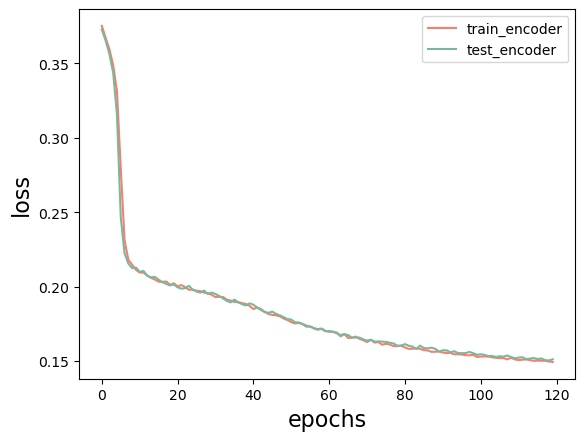

In [12]:
plt.plot(y_loss['train_encoder'], 'C1', label='train_encoder', color='#FE7C68')
plt.plot(y_loss['test_encoder'], 'C2', label='test_encoder',color='#76B99E')
plt.xlabel('epochs', fontsize=16)
plt.ylabel('loss', fontsize=16)
plt.legend()
plt.show()

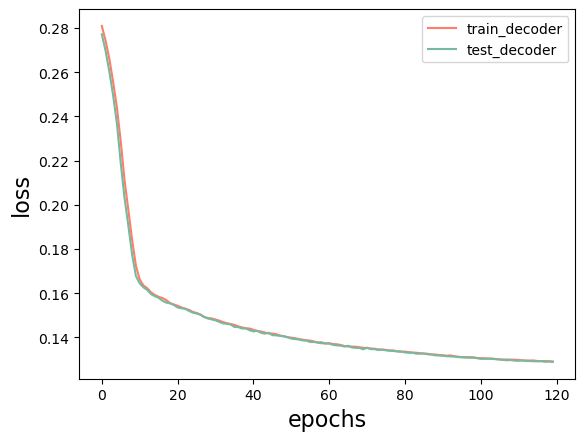

In [13]:


plt.plot(y_loss['train_decoder'],label='train_decoder', color='#FE7C68')
plt.plot(y_loss['test_decoder'],label='test_decoder',color='#76B99E')
plt.xlabel('epochs', fontsize=16)
plt.ylabel('loss', fontsize=16)
plt.legend()
plt.show()

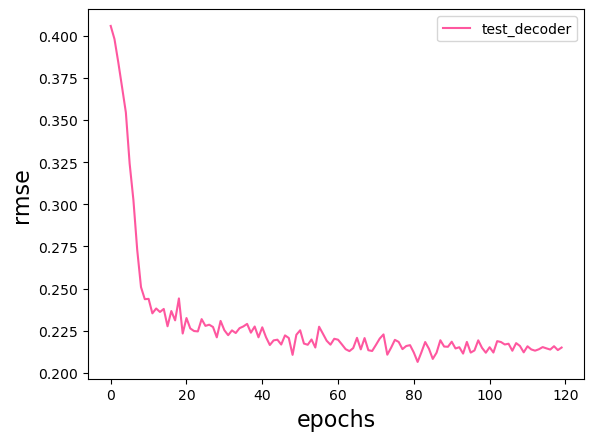

In [14]:
plt.plot(y_rmse['test_decoder'],label='test_decoder',color='#FE579F')

plt.xlabel('epochs', fontsize=16)
plt.ylabel('rmse', fontsize=16)
plt.legend()
plt.show()

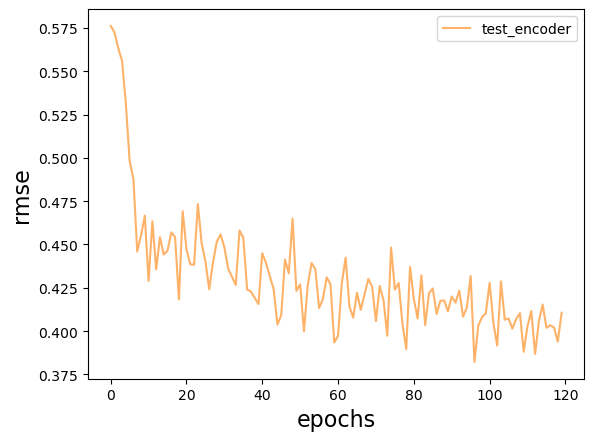

In [15]:

plt.plot(y_rmse['test_encoder'],label='test_encoder',color='#FEB268')
plt.xlabel('epochs', fontsize=16)
plt.ylabel('rmse', fontsize=16)
plt.legend()
plt.show()

In [16]:
test_encoder=[]
test_decoder=[]
best_mse=[]

y=test_data.iloc[:,-3:]
x=test_data.iloc[:,:26]

encoeder.eval()


torch_tensor = torch.tensor(x.values.astype(np.float32))
torch_tensor=torch_tensor.to(device)
y_encoded,y_decoded=encoeder(torch_tensor)
# with torch.no_grad():
#         encoeder.eval()
#         current_loss_test_encoder,current_loss_test_decoder =0.0,0.0
      
#         for i, (inputs_test, targets_test) in enumerate(test_dataloader):
#             inputs_test, targets_test = inputs_test.float().to(device), targets_test.float().to(device)
#             predictions_encoder,predictions_decoder = encoeder(inputs_test)
#             test_encoder.append(np.sqrt(mean_squared_error(predictions_encoder.cpu().detach().numpy(),targets_test.cpu().detach().numpy())))
#             test_decoder.append(np.sqrt(mean_squared_error(predictions_decoder.cpu().detach().numpy(),inputs_test.cpu().detach().numpy())))
#             if best_mse<np.sqrt(mean_squared_error(predictions_decoder.cpu().detach().numpy(),inputs_test.cpu().detach().numpy())):
                
#                 best_mse=np.sqrt(mean_squared_error(predictions_decoder.cpu().detach().numpy(),inputs_test.cpu().detach().numpy()))

print(np.sqrt(mean_squared_error(y_encoded.cpu().detach().numpy(),y)))
print(np.sqrt(mean_squared_error(y_decoded.cpu().detach().numpy(),x)))








NameError: name 'encoeder' is not defined

In [ ]:
cont=[]
rmse_encoder=[]
rmse_decoder=[]
x=[[0.01, 0.26659986, 0.41720563],
[0.02,0.2647994, 0.38934484],
[0.5, 0.26779914, 0.3864118],
[0.03, 0.26742324, 0.48824894],
[0.4,0.2698232, 0.3836432],
[0.9, 0.28630263, 0.38002953]]

for i in x:
    cont.append(i[0])
    rmse_decoder.append(i[2])
    rmse_decoder.append(i[1])


In [ ]:
native_decoder_rmse=[0.36341068, 0.3069731, 0.32761425, 0.28273553, 0.31394035, 0.3140564]
native_encoder_rmse=[0.66523343, 0.4892507, 0.4770927, 0.50294906, 0.5885116, 0.5885082]
plt.plot(native_decoder_rmse,label='nativeRMSE_decoder', color='#FE7C68')
plt.plot(rmse_decoder,label='RMSE_encoder',color='#76B99E')
plt.xlabel('epochs', fontsize=16)
plt.ylabel('loss', fontsize=16)
plt.legend()
plt.show()
